**Описание проекта**

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

У вас будет несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Задача 1: предсказание уровня удовлетворённости сотрудника

Для этой задачи заказчик предоставил данные с признаками:
- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

Задача 2: предсказание увольнения сотрудника из компании
<br>

Для этой задачи вы можете использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это quit — увольнение сотрудника из компании.

In [1]:
pip install --upgrade scikit-learn

     |████████████████████████████████| 10.9 MB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 302 kB 84.1 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install -q phik

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import mean_absolute_error, make_scorer


# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели для категориальных данных
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# загружаем нужные модели для количественных данных
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import f_classif, mutual_info_classif 


# Задача 1: предсказание уровня удовлетворённости сотрудника

## Шаг 1. Загрузка данных

### 1.1 Чтение файлов

In [4]:
try:
    data_job_train = pd.read_csv('tables_ML3/train_job_satisfaction_rate.csv'  , sep = ",")
except:
    data_job_train = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv'  , sep = ",")

In [5]:
try:
    data_test_features = pd.read_csv('tables_ML3/test_features.csv'  , sep = ",")
except:
    data_test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv'  , sep = ",")

In [6]:
try:
    data_test_target = pd.read_csv('tables_ML3/test_target_job_satisfaction_rate.csv'  , sep = ",")
except:
    data_test_target = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv'  , sep = ",")

### 1.2 Общая информация

####  1.2.1 Таблица data_job

In [7]:
data_job_train.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [8]:
data_job_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


**Типы данных указаны верно, также данные совпадают с документацией, есть 6 пропуска в "dept" и 4 в "level"**

####  1.2.2 Таблица data_test_features

In [9]:
data_test_features.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [10]:
data_test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


**Типы данных указаны верно,данные совпадают с документацией, есть пропуски в "dept" и в "level", будем заполнять пропуски в пайплайне, входные признаки совпадают с тренировочной выборкой**

####  1.2.3 Таблица data_test_features

In [11]:
data_test_target.head(5)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [12]:
data_test_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


**Типы данных указаны верно,данные совпадают с документацией, пропусков нет, целевой признак совпадает с тренировочной выборкой**

### 1.3 Вывод

1. Произвели выгрузку данных
2. Cверили типы данных, во всех таблицах все сошлось
3. Сверили данные с документацией, все совпало
4. Заметили наличие пропусков
5. Название столбцов везде в нормольном виде

## Шаг 2. Предобработка данных

### 2.1 Пропуски

In [13]:
data_job_train.name = "train"
data_test_features.name = "test_features"
data_test_target.name = "test_target"

In [14]:
def analys_None(*data):
    for item in data:
        print(f"-----{item.name}-----")
        print(item.isna().sum())
        print()

In [15]:
analys_None(data_job_train , data_test_features , data_test_target)

-----train-----
id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

-----test_features-----
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

-----test_target-----
id                       0
job_satisfaction_rate    0
dtype: int64



**Результаты совпали с пунктом "Общая информация"**

### 2.2 Дубликаты

In [16]:
#Поиск полных дубликатов
def analys_duplicates(*data):
    for item in data:
        print(f"-----{item.name}-----")
        print(len(item[item.duplicated()]))
        print()

In [17]:
analys_duplicates(data_job_train , data_test_features , data_test_target)

-----train-----
0

-----test_features-----
0

-----test_target-----
0



**Полные дубликаты во всех таблицах отсутствуют**

In [18]:
len(data_job_train[data_job_train["id"].duplicated()])

0

**Одинаковые id тоже остутствуют**

### 2.3 Категариальные переменные(неявные дубликаты)

In [19]:
# columns_data_job_train = data_job_train.select_dtypes(include=["object"]).columns
# data_test_features = data_test_features.select_dtypes(include=["object"]).columns
# data_test_target = data_test_target.select_dtypes(include=["object"]).columns

In [20]:
def analys_cat(data):
    col = data.select_dtypes(include=["object"]).columns
    print("-" * 20)
    print(data.name)
    print("-" * 20)
    for item in col:
        print(f"{item} - {len(data[item].unique())} , {data[item].unique()}")

In [21]:
analys_cat(data_job_train)

--------------------
train
--------------------
dept - 6 , ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level - 4 , ['junior' 'middle' 'sinior' nan]
workload - 3 , ['medium' 'high' 'low']
last_year_promo - 2 , ['no' 'yes']
last_year_violations - 2 , ['no' 'yes']


Неявные дубликаты отсутствуют

In [22]:
analys_cat(data_test_features)

--------------------
test_features
--------------------
dept - 7 , ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level - 4 , ['junior' 'middle' 'sinior' nan]
workload - 4 , ['medium' 'low' 'high' ' ']
last_year_promo - 2 , ['no' 'yes']
last_year_violations - 2 , ['no' 'yes']


Неявные дубликаты отсутствуют, однаков можем заметить, что в значениях тестовых данных встречается ' ' в столбцах "dept" и "level", учтем в пайплайне

### 2.4 Вывод

1. Есть пропуски, заполним в пайплайне
2. Полные дубликаты отсутствуют
3. Неявные дубликаты отсутствуют
4. В значениях тестовых данных встречается ' ' в столбцах "dept" и "level", учтем в пайплайне

## Шаг 3. Исследовательский анализ данных

### 3.1 Общий анализ

In [23]:
data_job_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,4000.0,544957.621000,257883.104622,100954.00,322836.75,534082.50,771446.00,999521.0
employment_years,4000.0,3.718500,2.542513,1.00,2.00,3.00,6.00,10.0
supervisor_evaluation,4000.0,3.476500,1.008812,1.00,3.00,4.00,4.00,5.0
salary,4000.0,33926.700000,14900.703838,12000.00,22800.00,30000.00,43200.00,98400.0
job_satisfaction_rate,4000.0,0.533995,0.225327,0.03,0.36,0.56,0.71,1.0


**Все значения выглядят реалистично**

### 3.2 Аномалии

In [24]:
def box_plots(data):
    for item in data.select_dtypes(exclude=["object"]).columns:
        if item != "id":
            data[item].plot(kind = "box");
            plt.title(item)
            plt.show()
            print("-" * 64)

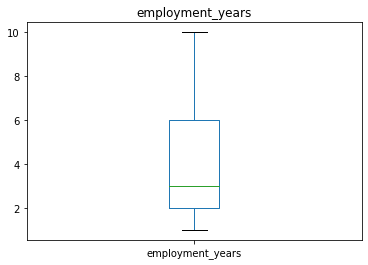

----------------------------------------------------------------


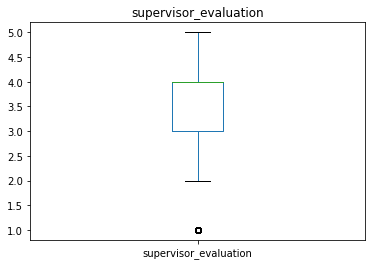

----------------------------------------------------------------


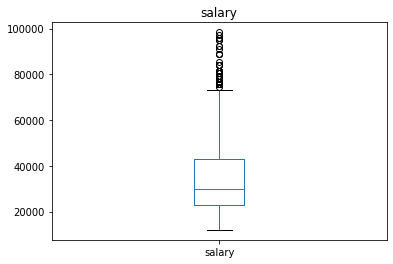

----------------------------------------------------------------


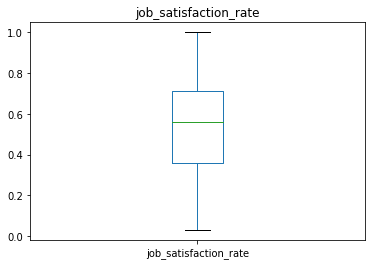

----------------------------------------------------------------


In [25]:
box_plots(data_job_train)

***

* __В столбце "supervisor_evaluation" видим выбросы, проанализируем их__

In [26]:
data_job_train["supervisor_evaluation"].unique()

array([1, 5, 2, 3, 4])

**Оценка качества работы сотрудника, которую дал руководитель оценивается целыми числами от 1 до 5, скорее всего сотрудники получают 1 балл намного реже, чем остальные оценки, что логично. 1 балл вполне реальная оценка так что это не выбросы. Ничего не удаляем**

***

* __В столбце "salary" видим выбросы, проанализируем их__

In [27]:
IQR = data_job_train["salary"].quantile(.75) - data_job_train["salary"].quantile(.25)
Q1 = data_job_train["salary"].quantile(.25)
Q3 = data_job_train["salary"].quantile(.75)
low = Q1 - 1.5 * IQR
high = Q3 + 1.5 * IQR
pr = (len(data_job_train.loc[data_job_train["salary"] < low ]) + len(data_job_train.loc[data_job_train["salary"] > high ])) / len(data_job_train["salary"])
print(f'Процент выбросов в стобце salary от общего количества - {round(pr * 100 , 3)} %')
print(f'Количество выбросов в стобце salary  - {len(data_job_train.loc[data_job_train["salary"] > high ])}')

Процент выбросов в стобце salary от общего количества - 1.5 %
Количество выбросов в стобце salary  - 60


В столбце "salary" выбросы находятся в промежутке от 75 тыс. до 100 тыс., это значит, что некоторые люди имеют высокую зарплату по сравнению с остальными, скорее всего это начальники, в этом нет ничего необычного. Также Процент выбросов в стобце salary от общего количества всего лишь 1.5 % от общего количества. Так что ничего не удаляем.<br><br> Но если модель будет иметь плохие показатели, то можно будет попробовать убрать данные выбросы

***

* __В столбцах "employment_years", "job_satisfaction_rate" выбросов нет__

### 3.3 Распределения

#### 3.3.1 Числовые данные

In [28]:
def hist_plots(data):
    for item in data.select_dtypes(exclude = ["object"]).columns:
        if item != "id":
            print(f"-----{item}-----")
            data[item].plot(kind = "hist" , bins = 30);
            plt.show()

-----employment_years-----


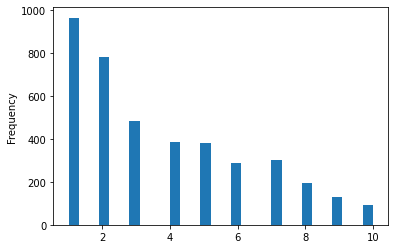

-----supervisor_evaluation-----


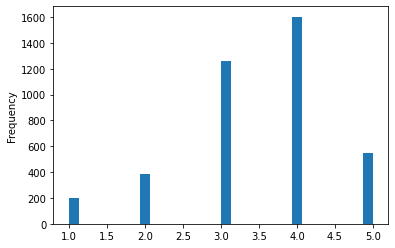

-----salary-----


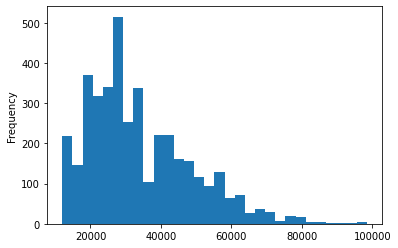

-----job_satisfaction_rate-----


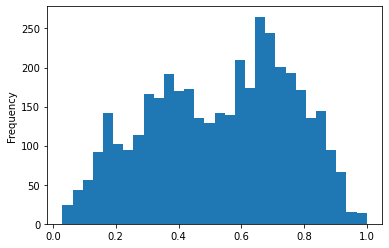

In [29]:
hist_plots(data_job_train)

In [30]:
data_job_train.select_dtypes(exclude=["object"]).columns

Index(['id', 'employment_years', 'supervisor_evaluation', 'salary',
       'job_satisfaction_rate'],
      dtype='object')

* __employment_years__

По графику можем заметить, что в компании большинство сотрудников работает от 1 до 2 лет, с опытом работы 3-7 лет в данной компании сотрудников меньше и 8-10 лет работает маленькое ккодичество сотрудников, то есть с возрастанием стажа, количество сотрудников уменьшается, что логично. График не похож на нормальное распредление.

* __supervisor_evaluation__

По графику можем заметить, что в компании сотрудники получают чаще всего оценки 3 и 4. График распределения скошен вправо

* __salary__

По графику можем заметить, что в компании большинство сотрудников получает зарплату от 12 тыс. до 30 тыс.Более 60 тыс. зарплату в данной компании получают маленькое количество сотрудников. График распределения скошен влево.

* __job_satisfaction_rate__

По графику можем заметить, что в компании большинство сотрудников имеет уровень удовлетворённости работой в компаниии около 0.4 или около 0.7, так как у графика две вериишины.

#### 3.3.2 Категориальные данные

In [31]:
def bar_plots(data):
    for item in data.select_dtypes(include = "object").columns:
            print(f"-----{item}-----")
            unique_values , counts = np.unique(data[item].dropna() , return_counts = True)
            plt.bar(unique_values , counts)
            # if item == "Популярная_категория":
            #     plt.xticks(rotation = 90)
            plt.show()

-----dept-----


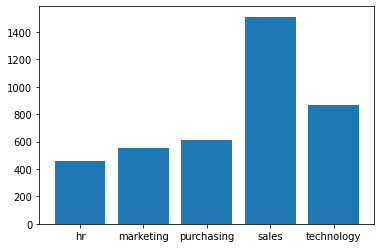

-----level-----


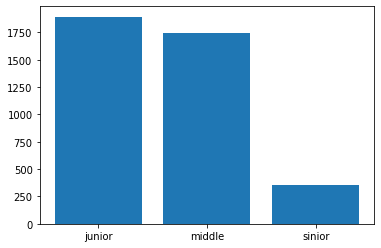

-----workload-----


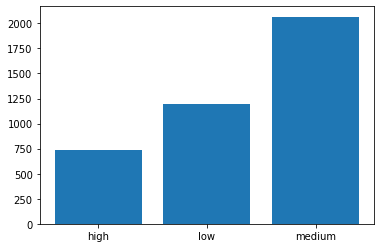

-----last_year_promo-----


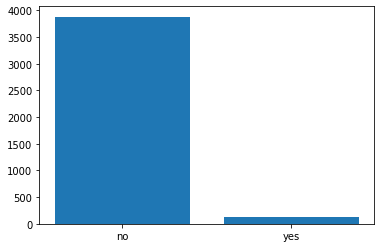

-----last_year_violations-----


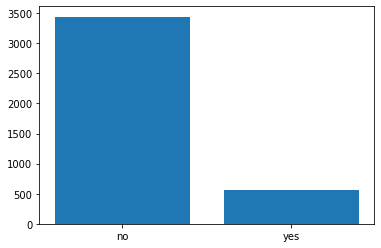

In [32]:
bar_plots(data_job_train)

In [33]:
data_job_train.select_dtypes(include=["object"]).columns

Index(['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations'], dtype='object')

Можем заметить что в столбцах:
<br>
1. dept - Сильно доминирует отдел sales по количеству работников,за ней идет technology,в остальных отделов сотрудников примерно равное количество.
2. level - намного больше значений junior и middle, значение sinior свтречается намного реже, что логично, высококвалифицированных специалистов меньше.
3. last_year_promo - намного больше значений нет, чем да, занчит сотрудников редко повышают в данной компании.
4. last_year_violations - намного больше значений нет, чем да, значит сотрудники редко нарушали трудовой договор за последний год.
5. workload - категории по популярности располагаются в следующем порядке(от меньшего к большему):
<br>
low, medium, high.



###  3.4 Анализ тестовых данных

In [34]:
data_test_features.head(3)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200


In [35]:
data_test_target.head(3)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60


In [36]:
dt_f = data_test_features.merge(data_test_target , on = "id")

In [37]:
dt_f.head(3)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64


In [38]:
dt_f.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.21350,253851.326129,100298.00,339052.00,550793.00,765763.75,999029.0
employment_years,2000.0,3.66650,2.537222,1.00,1.00,3.00,6.00,10.0
supervisor_evaluation,2000.0,3.52650,0.996892,1.00,3.00,4.00,4.00,5.0
salary,2000.0,34066.80000,15398.436729,12000.00,22800.00,30000.00,43200.00,96000.0
job_satisfaction_rate,2000.0,0.54878,0.220110,0.03,0.38,0.58,0.72,1.0


**Все значения выглядят реалистично и похожи на тестовые**

#### Аномалии

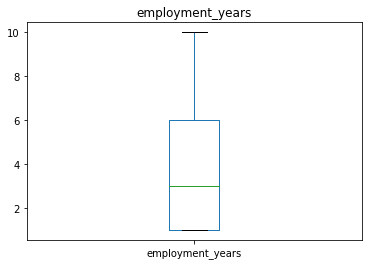

----------------------------------------------------------------


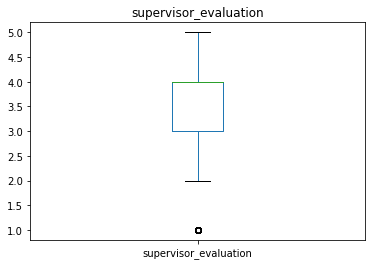

----------------------------------------------------------------


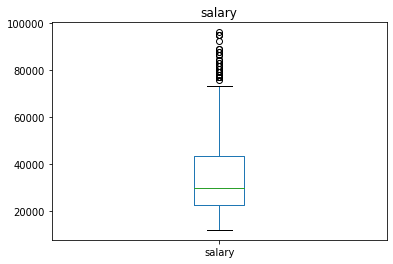

----------------------------------------------------------------


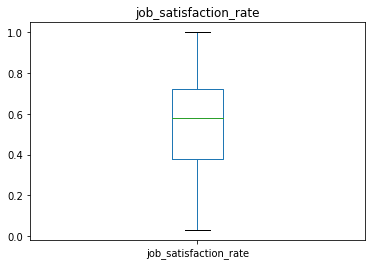

----------------------------------------------------------------


In [39]:
box_plots(dt_f)

Анализ аномалий тестовой выброки совпадает с анализом тренировочной выборки

#### Распределения

-----employment_years-----


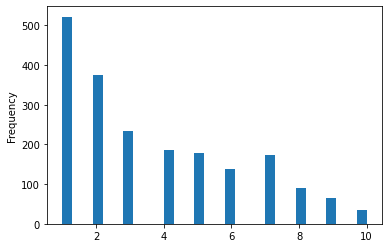

-----supervisor_evaluation-----


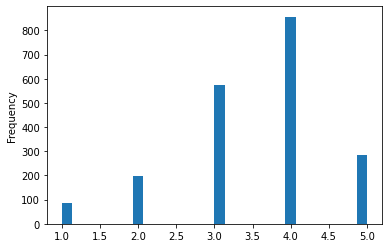

-----salary-----


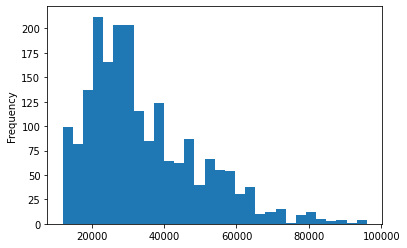

-----job_satisfaction_rate-----


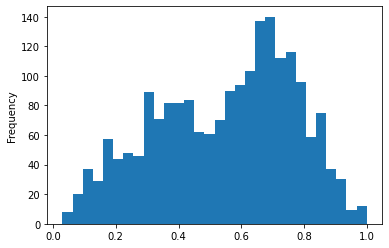

In [40]:
hist_plots(dt_f)

Анализ распределений числовых данных тестовой выброки совпадает с анализом тренировочной выборки

-----dept-----


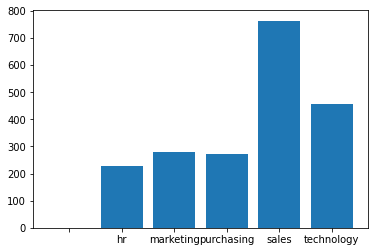

-----level-----


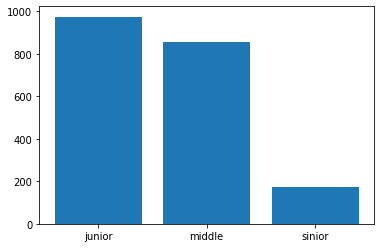

-----workload-----


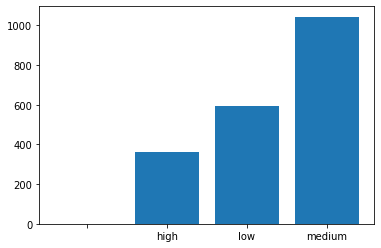

-----last_year_promo-----


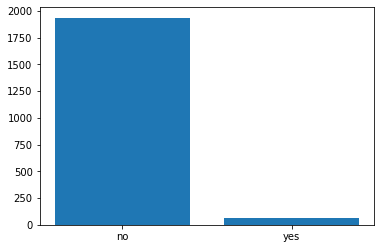

-----last_year_violations-----


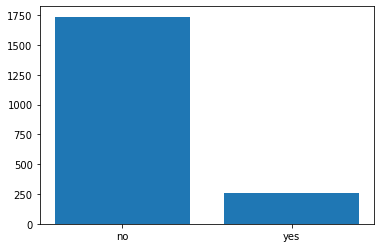

In [41]:
bar_plots(dt_f)

Анализ распределений категориальных данных тестовой выброки совпадает с анализом тренировочной выборки, также можем заметить путые строки в dept и workload

#### Вывод

Тестовые данные достаточно сильно похожи на обучающие

### 3.5 Вывод

В ходе исследовательского анализа мы выяснили:

1. Во всех таблицах минимальные, средние и медианные значения выглядят правдоподобно.
2. Категориальные значения также выглядят правдоподобно.
3. Проанализировали таблицы на анамалии, ничего не удалили.
5. Проанализировали распределения во всех столбцах всех таблиц, данных с номральным распределением очень мало, так что коэфициент кореляции Пирсона использовать не будем.
6. В пайпалайне будем Imputer для вставки пропущенных значений





## Шаг 4. Корреляционный анализ

In [42]:
arr = [x for x in data_job_train.columns if x!="id"]

In [43]:
arr

['dept',
 'level',
 'workload',
 'employment_years',
 'last_year_promo',
 'last_year_violations',
 'supervisor_evaluation',
 'salary',
 'job_satisfaction_rate']

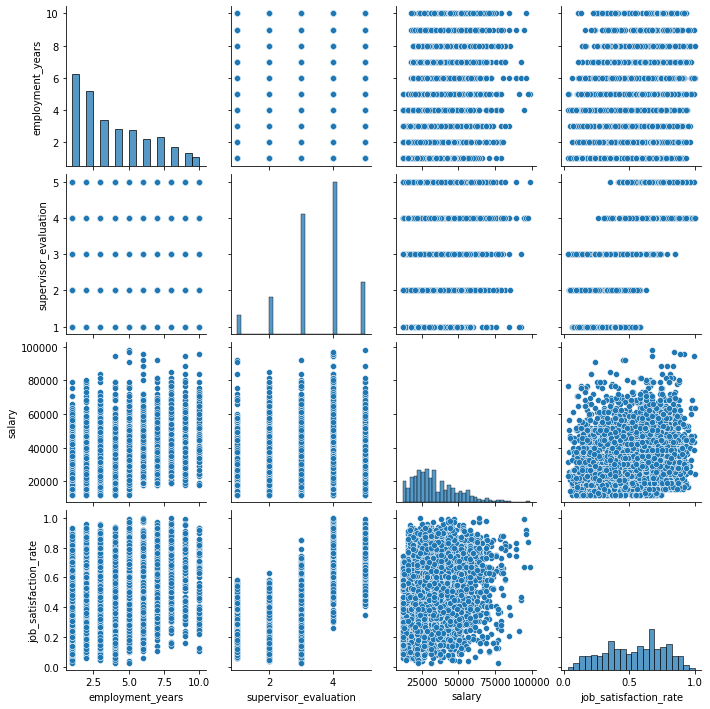

In [44]:
sns.pairplot(data_job_train[arr]);

Можем сразу заметить линейную свзяь между "job_satisfaction_rate" и "supervisor_evaluation" и небольшую свзяь между "salary" и "job_satisfaction_rate"

### 4.1 Кореляция с целевым признаком

Так как много входных признаков категориальных, то будем использовать phik_matrix

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


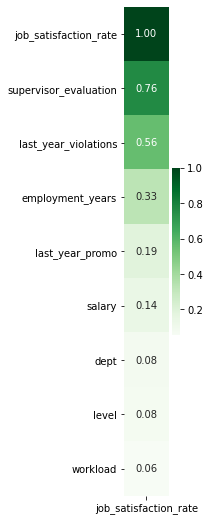

In [45]:
plt.figure(figsize = (1,9))
sns.heatmap(data_job_train[arr].phik_matrix()[["job_satisfaction_rate"]].sort_values(by = "job_satisfaction_rate" , ascending = False) , annot = True , cmap = "Greens" , fmt = ".2f");

Можем заметить, что:
1. Сильная кореляция с целевым признаком у 'supervisor_evaluation'
2. Средняя кореляция с целевым признаком у "last_year_violations" , "employment_years" ,
3. Слабая кореляция с целевым признаком у "last_year_promo" , "salary"
4. Нет кореляции с целевым признаком у "dept", "level", "workload"

### 4.2 Кореляция между входными признакками(мультиколлинеарность)

In [46]:
arr = [x for x in arr if x!="job_satisfaction_rate"]

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary']


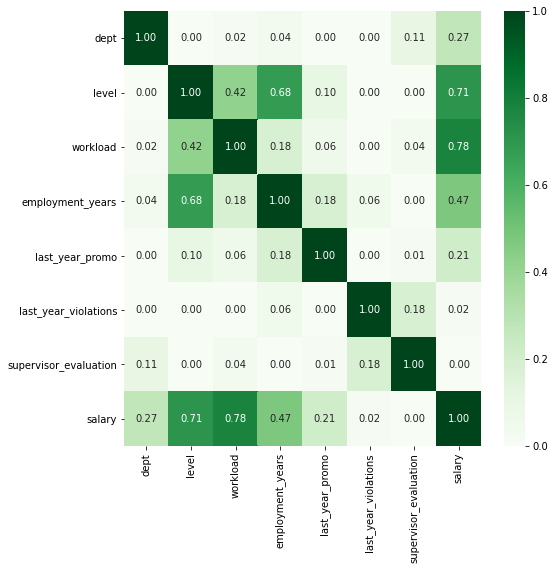

In [47]:
plt.figure(figsize=(8 , 8))
sns.heatmap(data_job_train[arr].phik_matrix() , annot = True , cmap = "Greens" , fmt = ".2f");

Достаточно сильная корреляция у:
<br>
* "level" и "employment_years", "level" и "salary"
* "workload" и "salary"
<br>
<br>
Мультиколлениарности не наблюдается, однако если модель будет себя плохо показывать, то можно будет попробовать удалить корелирующие признаки

### 4.3 Вывод

1. Сильная кореляция с целевым признаком у 'supervisor_evaluation'
2. Нет кореляции с целевым признаком у "dept", "level", "workload"
3. Мультиколлениарности не наблюдается

## Шаг 5. Использование пайплайнов(Подготовка данных)

In [48]:
cl_d = [x for x in data_job_train.columns if x!="job_satisfaction_rate" and x!="id"]

In [49]:
cl_d

['dept',
 'level',
 'workload',
 'employment_years',
 'last_year_promo',
 'last_year_violations',
 'supervisor_evaluation',
 'salary']

In [50]:
len(data_job_train[data_job_train[cl_d].duplicated()])

1492

In [51]:
data_job_train = data_job_train.drop_duplicates(subset = cl_d)

In [52]:
X_train = data_job_train.drop(["job_satisfaction_rate", "id"] , axis = 1)

In [53]:
len(X_train[X_train.duplicated()])

0

In [54]:
y_train = data_job_train["job_satisfaction_rate"].copy()

In [55]:
X_train.head(3)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,sales,junior,medium,2,no,no,1,24000
1,hr,junior,high,2,no,no,5,38400
2,sales,junior,low,1,no,no,2,12000


In [56]:
y_train.head(3)

0    0.58
1    0.76
2    0.11
Name: job_satisfaction_rate, dtype: float64

In [57]:
X_train.shape

(2508, 8)

In [58]:
y_train.shape

(2508,)

In [59]:
col_cat_ohe = [x for x in X_train.select_dtypes(include=["object"]).columns if x!= "level" and x!="workload"]
col_cat_ord = ["level" , "workload"]
col_num = X_train.select_dtypes(exclude=["object"]).columns

In [60]:
col_num

Index(['employment_years', 'supervisor_evaluation', 'salary'], dtype='object')

In [61]:
col_cat_ohe

['dept', 'last_year_promo', 'last_year_violations']

In [62]:
col_cat_ord

['level', 'workload']

In [63]:
ohe_pipe = Pipeline(
    [
        ("Imputer_cat_nan" , SimpleImputer(missing_values = np.nan , strategy = "most_frequent")),
        ("Imputer_cat_void" , SimpleImputer(missing_values = " " , strategy = "most_frequent")),
        ("ohe" , OneHotEncoder(drop="first"))
    ]
)

In [64]:
ord_pipe = Pipeline(
    [
        ("Imputer_cat_nan_1" , SimpleImputer(missing_values = np.nan , strategy = "most_frequent")),
        ("Imputer_cat_void_1" , SimpleImputer(missing_values = " " , strategy = "most_frequent")),
        ("ord" , OrdinalEncoder(categories=[['junior', 'middle', "sinior"] , ['low', 'medium' , "high"]]))
    ]
) 

In [65]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.3.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /opt/conda/lib/python3.9/site-packages
Requires: numpy, joblib, threadpoolctl, scipy
Required-by: pyod, lightgbm


In [66]:
data_preprocessor = ColumnTransformer(
    [
        ("ohe" , ohe_pipe , col_cat_ohe),
        ("ord" , ord_pipe , col_cat_ord),
        ("num" , StandardScaler() , col_num)
    ]
)

In [67]:
pipe_final = Pipeline(
    [
        ("preprocessor" , data_preprocessor),
        ("models" , KNeighborsRegressor())
    ]
)

In [68]:
# pipe_final.fit(X_train , y_train)

# y_pred = pipe_final.predict(data_test_features)

# tmp = data_test_features.merge(data_test_target , on = "id")

# data_test_target

# mean_absolute_error(tmp["job_satisfaction_rate"] , y_pred)

In [69]:
ran_st = 42

In [70]:
param_grid = [
    #Деревья
    {
        "models" : [DecisionTreeRegressor(random_state = ran_st)],
        "models__max_depth" : range(10,30),
        "models__max_features" : range(10,30),
        "preprocessor__num" : [StandardScaler(), MinMaxScaler() , 'passthrough']
        
    },
    #ближайшие соседи
    {
        "models" : [KNeighborsRegressor()],
        "models__n_neighbors" : range(5,30),
        "models__weights" : ["uniform" , "distance"],
        "models__metric" : ["euclidean" , "cityblock"],
        "preprocessor__num" : [StandardScaler(), MinMaxScaler(),  'passthrough']
    },
    #метод опорных векторов
    {
        "models" : [SVR()],
        "models__kernel" : ["linear", "poly", "rbf", "sigmoid"],
        "models__degree" : range(2 , 7),
        "preprocessor__num": [StandardScaler(), MinMaxScaler(), 'passthrough']
        
    },
    #Линейная Регрессия
    {
        'models': [LinearRegression()],
        "preprocessor__num": [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
    
]

Создаем собственную метрику SMAPE

In [71]:
def SMAPE(A , F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))


In [72]:
scorer_smape = make_scorer(SMAPE , greater_is_better=False)

In [73]:
# actual = np.array([12, 13, 14, 15, 15,22, 27])
# forecast = np.array([11, 13, 14, 14, 15, 16, 18])

### 5.1 Вывод

Создали пайплайн с моделями:<br>
1. DecisionTreeRegressor
2. KNeighborsRegressor
3. SVR
4. LinearRegression
<br>
В качестве кодировщиков будем сипользовать OneHotEncoder для столбцов 'dept', 'last_year_promo', 'last_year_violations' и OrdinalEncoder для столбцов 'level', 'workload'
<br>
Для масштабирования будем использовать StandardScaler(), MinMaxScaler()
<br>
Для каждой модели будем подбирать разные параметры
<br>
Создали свою метрику SMAPE



## Шаг 6. Обучение моделей

In [74]:
random_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv = 5,
    scoring=scorer_smape,
    random_state=ran_st,
    n_jobs=-1,
    n_iter=100
)

In [75]:
random_search.fit(X_train , y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('ohe',
                                                                               Pipeline(steps=[('Imputer_cat_nan',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('Imputer_cat_void',
                                                                                                SimpleImputer(missing_values=' ',
                                                                                                              strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first'))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              (...
                                                               'passthrough']},
                                        {'models': [SVR()],
                                         'models__degree': range(2, 7),
                                         'models__kernel': ['linear', 'poly',
                                                            'rbf', 'sigmoid'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(SMAPE, greater_is_better=False))

In [76]:
result = pd.DataFrame(random_search.cv_results_)
with pd.option_context('max_colwidth', 3000):
    display(result[['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score').head(10))

,rank_test_score,param_models,mean_test_score,params
59,1,SVR(),-17.112082,"{'preprocessor__num': StandardScaler(), 'models__kernel': 'rbf', 'models__degree': 3, 'models': SVR()}"
90,2,DecisionTreeRegressor(random_state=42),-19.239334,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 15, 'models__max_depth': 11, 'models': DecisionTreeRegressor(random_state=42)}"
88,2,DecisionTreeRegressor(random_state=42),-19.239334,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 13, 'models__max_depth': 11, 'models': DecisionTreeRegressor(random_state=42)}"
24,4,DecisionTreeRegressor(random_state=42),-19.265812,"{'preprocessor__num': 'passthrough', 'models__max_features': 11, 'models__max_depth': 11, 'models': DecisionTreeRegressor(random_state=42)}"
37,5,DecisionTreeRegressor(random_state=42),-19.350740,"{'preprocessor__num': StandardScaler(), 'models__max_features': 23, 'models__max_depth': 11, 'models': DecisionTreeRegressor(random_state=42)}"
39,6,DecisionTreeRegressor(random_state=42),-19.366787,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 11, 'models__max_depth': 12, 'models': DecisionTreeRegressor(random_state=42)}"
45,7,DecisionTreeRegressor(random_state=42),-19.445507,"{'preprocessor__num': StandardScaler(), 'models__max_features': 15, 'models__max_depth': 12, 'models': DecisionTreeRegressor(random_state=42)}"
52,7,DecisionTreeRegressor(random_state=42),-19.445507,"{'preprocessor__num': StandardScaler(), 'models__max_features': 11, 'models__max_depth': 12, 'models': DecisionTreeRegressor(random_state=42)}"
72,9,DecisionTreeRegressor(random_state=42),-19.569354,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 11, 'models__max_depth': 13, 'models': DecisionTreeRegressor(random_state=42)}"
79,10,DecisionTreeRegressor(random_state=42),-19.584494,"{'preprocessor__num': 'passthrough', 'models__max_features': 17, 'models__max_depth': 13, 'models': DecisionTreeRegressor(random_state=42)}"


In [79]:
X_train

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,sales,junior,medium,2,no,no,1,24000
1,hr,junior,high,2,no,no,5,38400
2,sales,junior,low,1,no,no,2,12000
3,technology,junior,low,4,no,no,2,18000
4,hr,junior,medium,1,no,no,3,22800
...,...,...,...,...,...,...,...,...
3983,hr,middle,high,7,no,no,4,60000
3985,technology,middle,low,10,no,no,4,33600
3986,marketing,middle,low,5,no,no,4,20400
3993,hr,sinior,high,6,no,no,4,80400


In [80]:
ml = random_search.best_estimator_

In [81]:
y_pred = ml.predict(data_test_features.drop("id" , axis = 1))

In [82]:
tmp = data_test_features.merge(data_test_target , on = "id")

In [83]:
SMAPE(tmp["job_satisfaction_rate"] , y_pred)

14.680664148146764

***

In [84]:
prep = random_search.best_estimator_.named_steps.preprocessor
X = prep.transform(X_train)
lr = LinearRegression()
lr.fit(X , y_train)
y_pred_lr = lr.predict(prep.transform(data_test_features.drop("id" , axis = 1)))


In [85]:
SMAPE(tmp["job_satisfaction_rate"] , y_pred_lr)

23.514171262326602

### 6.1 Вывод

Мы построили пайплайн и обучали модели с разными гиперпараматрами. В итоге лучший результат по метрике SMAPE дала модель SVR() с гипер парамаетрами: 'models__kernel': 'rbf', 'models__degree': 3, и масштабируемость с помощью StandardScaler(). При данных параметрах модель показала SMAPE = 14.68 на тестовой выборке, что удовлетворяет критерию успеха : SMAPE <= 15

## Шаг 7. Вывод

**Линейная регрессия показала плохой результат(SMAPE = 23.51 на тестовой), так как целевой признак линейно почти не зависит от выходных признаков, в то всремя как лучшей моделью оказалась SVR() c нелинейным ядром, так как данная модель способна предсказывать линейно не зависящие данные. В итоге мы получили можедель которая предсказывает уровень удовлетворённости сотрудника работой в компании с точность 14.68 по SMAPE()**

# Задача 2: предсказание увольнения сотрудника из компании

## Шаг 1. Загрузка данных

In [86]:
try:
    data_quit_train = pd.read_csv('tables_ML3/train_quit.csv'  , sep = ",")
except:
    data_quit_train = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv'  , sep = ",")

In [87]:
try:
    data_test_target_quit = pd.read_csv('tables_ML3/test_target_quit.csv'  , sep = ",")
except:
    data_test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv'  , sep = ",")

### 1.2 Общая информация

In [88]:
data_quit_train.head(4)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes


In [89]:
data_quit_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


**Типы данных указаны верно, также данные совпадают с документацией, пропуски отсутствуют**

## Шаг 2. Предобработка данных

### 2.1 Пропуски

In [90]:
data_quit_train.name = "train_quit"
data_test_target_quit.name = "target_test_quit"

In [91]:
analys_None(data_quit_train , data_test_target_quit)

-----train_quit-----
id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

-----target_test_quit-----
id      0
quit    0
dtype: int64



Пропуски отсутствуют

### 2.2 Дубликаты

In [92]:
analys_duplicates(data_quit_train , data_test_target_quit)

-----train_quit-----
0

-----target_test_quit-----
0



**Полные дубликаты во всех таблицах отсутствуют**

In [93]:
len(data_job_train[data_job_train["id"].duplicated()])

0

Одинаковые id тоже остутствуют

### 2.3 Категариальные переменные(неявные дубликаты)

In [94]:
analys_cat(data_quit_train)

--------------------
train_quit
--------------------
dept - 5 , ['sales' 'purchasing' 'marketing' 'technology' 'hr']
level - 3 , ['middle' 'junior' 'sinior']
workload - 3 , ['high' 'medium' 'low']
last_year_promo - 2 , ['no' 'yes']
last_year_violations - 2 , ['no' 'yes']
quit - 2 , ['no' 'yes']


In [95]:
analys_cat(data_test_target_quit)

--------------------
target_test_quit
--------------------
quit - 2 , ['yes' 'no']


Неявные дубликаты отсутствуют

### 2.4 Вывод

1. Полные дубликаты отсутствуют
2. Неявные дубликаты отсутствуют
3. Пропуски отсутствуют


## Шаг 3. Исследовательский анализ данных

### 3.1 Общий анализ

In [96]:
data_quit_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,4000.0,552099.28375,260158.031387,100222.0,327785.75,546673.0,781497.75,999915.0
employment_years,4000.0,3.70150,2.541852,1.0,2.00,3.0,6.00,10.0
supervisor_evaluation,4000.0,3.47475,1.004049,1.0,3.00,4.0,4.00,5.0
salary,4000.0,33805.80000,15152.415163,12000.0,22800.00,30000.0,43200.00,96000.0


**Все значения выглядят реалистично**

### 3.2 Аномалии

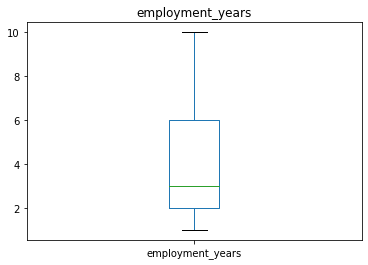

----------------------------------------------------------------


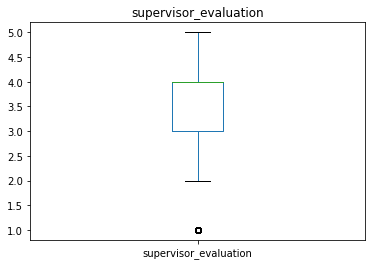

----------------------------------------------------------------


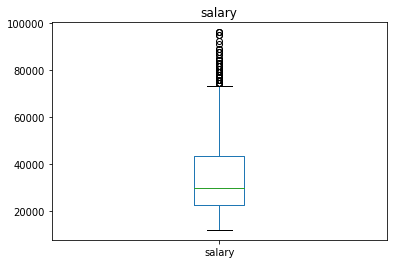

----------------------------------------------------------------


In [97]:
box_plots(data_quit_train)

Выбросы во всех столбцах являются вполне нормальными значениями, как в задаче 1, удалять ничего не будем

### 3.3 Распределения

#### 3.3.1 Числовые данные

-----employment_years-----


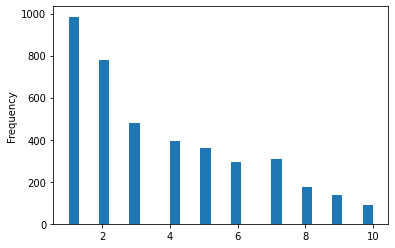

-----supervisor_evaluation-----


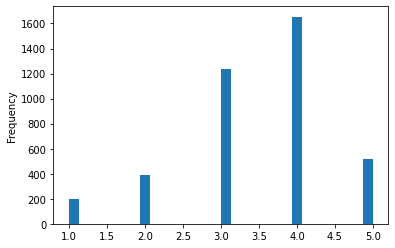

-----salary-----


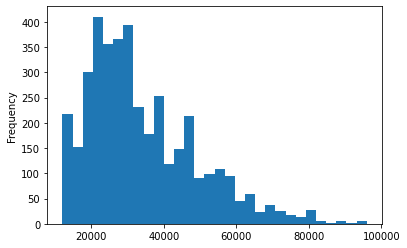

In [98]:
hist_plots(data_quit_train)

* __employment_years__

По графику можем заметить, что в компании большинство сотрудников работает от 1 до 2 лет, с опытом работы 3-7 лет в данной компании сотрудников меньше и 8-10 лет работает маленькое ккодичество сотрудников, то есть с возрастанием стажа, количество сотрудников уменьшается, что логично. График не похож на нормальное распредление.

* __supervisor_evaluation__

По графику можем заметить, что в компании сотрудники получают чаще всего оценки 3 и 4. График распределения скошен вправо

* __salary__

По графику можем заметить, что в компании большинство сотрудников получает зарплату от 12 тыс. до 30 тыс.Более 60 тыс. зарплату в данной компании получают маленькое количество сотрудников. График распределения скошен влево.

#### 3.3.2 Категориальные данные

-----dept-----


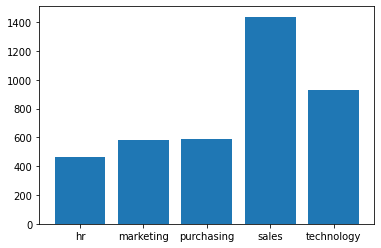

-----level-----


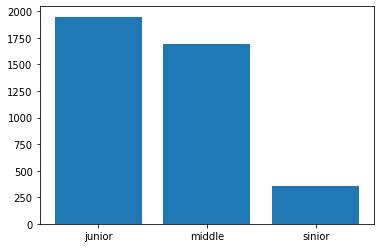

-----workload-----


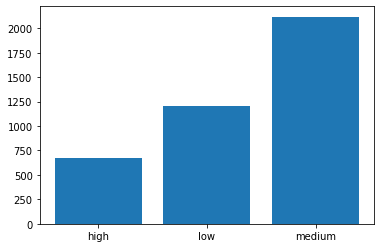

-----last_year_promo-----


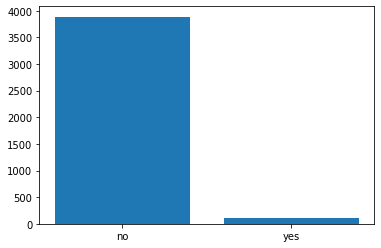

-----last_year_violations-----


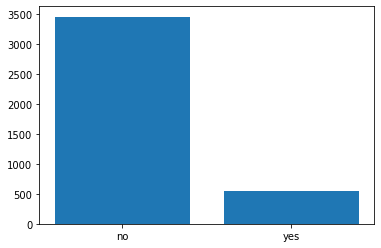

-----quit-----


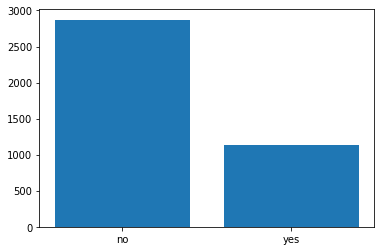

In [99]:
bar_plots(data_quit_train)

Можем заметить что в столбцах:
<br>
1. dept - Сильно доминирует отдел sales по количеству работников,за ней идет technology,в остальных отделов сотрудников примерно равное количество.
2. level - намного больше значений junior и middle, значение sinior свтречается намного реже, что логично, высококвалифицированных специалистов меньше.
3. last_year_promo - намного больше значений нет, чем да, занчит сотрудников редко повышают в данной компании.
4. last_year_violations - намного больше значений нет, чем да, значит сотрудники редко нарушали трудовой договор за последний год.
5. workload - категории по популярности располагаются в следующем порядке(от меньшего к большему):
<br>
high, low, medium.



**В целевом признаке значений "no" намного больше, чем yes, что логично. Если качество модели будет недостаточно хороша, то можем попробовать сэмплирование**

**Вывод**
<br>
1. Во всех таблицах минимальные, средние и медианные значения выглядят правдоподобно.
2. Категориальные значения также выглядят правдоподобно.
3. Проанализировали таблицы на анамалии, ничего не удалили.
5. Проанализировали распределения во всех столбцах всех таблиц, данных с номральным распределением очень мало, так что коэфициент кореляции Пирсона использовать не будем.


#### Тестовые данные

-----quit-----


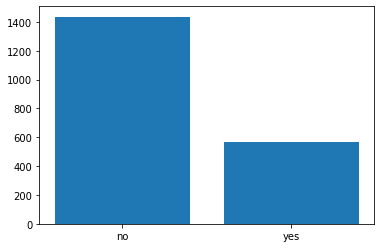

In [100]:
bar_plots(data_test_target_quit)

**Анализ тестовых данных в пункте 3.4 задачи 1, так как тестовые данные совпадают. Тестовые данные достаточно сильно похожи на обучающие.**

### 3.4  Портрет «уволившегося сотрудника».

In [101]:
data_quit_train.groupby(['dept'])['quit'].value_counts(normalize=True)

dept        quit
hr          no      0.750000
            yes     0.250000
marketing   no      0.719931
            yes     0.280069
purchasing  no      0.717687
            yes     0.282313
sales       no      0.716968
            yes     0.283032
technology  no      0.702586
            yes     0.297414
Name: quit, dtype: float64

Скорее всего работает в отделе sales или technology или purchasing или marketing, в hr вероятность меньше

In [102]:
data_quit_train.groupby(['workload'])['quit'].value_counts(normalize=True)

workload  quit
high      no      0.820475
          yes     0.179525
low       no      0.570364
          yes     0.429636
medium    no      0.769594
          yes     0.230406
Name: quit, dtype: float64

Также имеет маленький уровень загруженности

In [103]:
quit_pd = data_quit_train.loc[data_quit_train["quit"] == "yes"].copy()

In [104]:
quit_pd["salary"].mean()

23885.106382978724

In [105]:
data_quit_train.loc[data_quit_train["quit"] == "no" , "salary"].mean()

37702.22841225627

Имели зарплату примерно 24 тыс., в то время как работники, работающие до сих пор в камапании имеют среднюю зарплату примерно 38 тыч.

In [106]:
data_quit_train.groupby(['level'])['quit'].value_counts(normalize=True)

level   quit
junior  yes     0.514623
        no      0.485377
middle  no      0.936246
        yes     0.063754
sinior  no      0.952381
        yes     0.047619
Name: quit, dtype: float64

Имеет уровень junior

In [107]:
data_quit_train.groupby(['last_year_promo'])['quit'].value_counts(normalize=True)

last_year_promo  quit
no               no      0.710059
                 yes     0.289941
yes              no      0.991150
                 yes     0.008850
Name: quit, dtype: float64

Работал без повышения

In [108]:
data_quit_train.groupby(['employment_years'])['quit'].value_counts(normalize=True)

employment_years  quit
1                 yes     0.608122
                  no      0.391878
2                 no      0.626770
                  yes     0.373230
3                 no      0.659708
                  yes     0.340292
4                 no      0.931298
                  yes     0.068702
5                 no      0.936464
                  yes     0.063536
6                 no      0.966216
                  yes     0.033784
7                 no      0.977273
                  yes     0.022727
8                 no      0.982759
                  yes     0.017241
9                 no      0.977941
                  yes     0.022059
10                no      0.966667
                  yes     0.033333
Name: quit, dtype: float64

Работал в компании от 1го до 3х лет

### Вывод 

Скорее всего работает в отделе sales или technology или purchasing или marketing, в hr вероятность меньше, с уровнем профессионализма junior. Имел маленький уровень загруженности. Имел зарплату примерно 24 тыс., в то время как работники, работающие до сих пор в камапании имели среднюю зарплату примерно 38 тыч. Работал без повышения. Также скорее всего работал в компании от 1го до 3х лет. 

### 3.5 Анализ

In [109]:
df_two_target = data_test_target.merge(data_test_target_quit , on = "id")

In [110]:
df_two_target.head(3)

,id,job_satisfaction_rate,quit
0,130604,0.74,no
1,825977,0.75,no
2,418490,0.60,yes


In [111]:
df_two_target_yes = df_two_target.loc[df_two_target["quit"] == "yes"].copy()

In [112]:
df_two_target_no = df_two_target.loc[df_two_target["quit"] == "no"].copy()

In [113]:
df_two_target_yes.head(3)

,id,job_satisfaction_rate,quit
2,418490,0.60,yes
4,826430,0.08,yes
20,508688,0.58,yes


In [114]:
df_two_target_no.head(3)

,id,job_satisfaction_rate,quit
0,130604,0.74,no
1,825977,0.75,no
3,555320,0.72,no


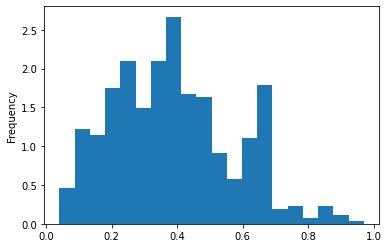

In [115]:
df_two_target_yes["job_satisfaction_rate"].plot(kind = "hist" , bins = 20, density=True);

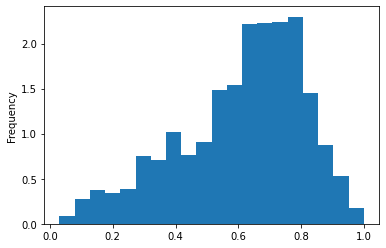

In [116]:
df_two_target_no["job_satisfaction_rate"].plot(kind = "hist" , bins = 20, density=True);

### Вывод 

По графикам распределений можем увидеть, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник.У уволившихся сотрудниклв "job_satisfaction_rate" меньше(большая часть в районе 0.4), а у работающих до сих пор в районе 0.7 - 0.8

## Шаг 4. Добавление нового входного признака

In [117]:
data_quit_train["job_satisfaction_rate"] = ml.predict(data_quit_train.drop(["id" , "quit"] , axis = 1))

In [118]:
data_quit_train.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.577493
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.799085
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.336506
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.262114
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.688022


In [119]:
data_test_features_2 = data_test_features.copy()

In [120]:
data_test_features_2["job_satisfaction_rate"] = ml.predict(data_test_features_2.drop("id" , axis = 1))

### Вывод

Добавили "job_satisfaction_rate", предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

## Шаг 5. Корреляционный анализ

### 5.1 Кореляция с целевым признаком

In [121]:
arr = [x for x in data_quit_train.columns if x!="id"]

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


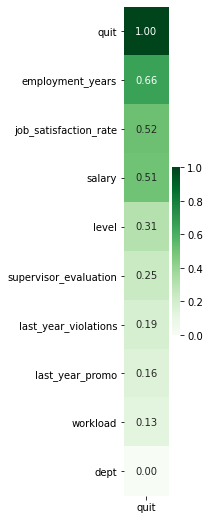

In [122]:
plt.figure(figsize = (1,9))
sns.heatmap(data_quit_train[arr].phik_matrix()[["quit"]].sort_values(by = "quit" , ascending = False) , annot = True , cmap = "Greens" , fmt = ".2f");

Можем заметить, что:

1. Средняя кореляция с целевым признаком у "last_year_violations" , "employment_years" , "job_satisfaction_rate", "salary"
2. Слабая кореляция с целевым признаком у  "level", "supervisor_evaluation", "last_year_promo", "last_year_violations"
3. Нет кореляции с целевым признаком у "dept", "workload"

In [123]:
arr = [x for x in arr if x!="quit"]

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


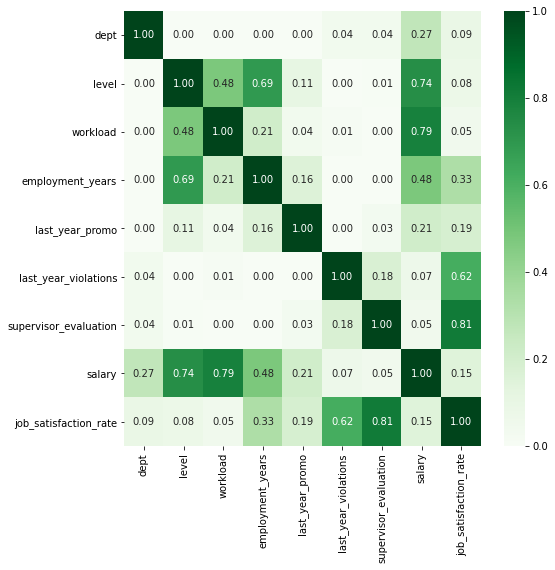

In [124]:
plt.figure(figsize=(8 , 8))
sns.heatmap(data_quit_train[arr].phik_matrix() , annot = True , cmap = "Greens" , fmt = ".2f");

Мультиколлениарности не наблюдается, однако если модель будет себя плохо показывать, то можно будет попробовать удалить корелирующие признаки

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'> 👍</font>

## Шаг 6. Подготовка данных

yes - 1<br>
no - 0

In [125]:
data_quit_train["quit"] = data_quit_train["quit"].apply(lambda x: 1 if x == "yes" else 0)

In [126]:
cl_d_2 = [x for x in data_quit_train.columns if x!="quit" and x!="id"]

In [127]:
cl_d_2

['dept',
 'level',
 'workload',
 'employment_years',
 'last_year_promo',
 'last_year_violations',
 'supervisor_evaluation',
 'salary',
 'job_satisfaction_rate']

In [128]:
len(data_quit_train[data_quit_train[cl_d_2].duplicated()])

1545

In [129]:
data_quit_train = data_quit_train.drop_duplicates(subset = cl_d_2)

In [130]:
len(data_quit_train[data_quit_train[cl_d_2].duplicated()])

0

In [131]:
X_train_2 = data_quit_train.drop(["id" , "quit"] , axis = 1)

In [132]:
len(X_train_2[X_train_2.duplicated()])

0

In [133]:
col_cat_ohe = [x for x in X_train.select_dtypes(include=["object"]).columns if x!= "level" and x!="workload"]
col_cat_ord = ["level" , "workload"]
col_num = X_train.select_dtypes(exclude=["object"]).columns

ord_pipe = Pipeline(
    [
        ("Imputer_cat_nan_1" , SimpleImputer(missing_values = np.nan , strategy = "most_frequent")),
        ("Imputer_cat_void_1" , SimpleImputer(missing_values = " " , strategy = "most_frequent")),
        ("ord" , OrdinalEncoder(categories=[['junior', 'middle', "sinior"] , ['low', 'medium' , "high"]]))
    ]
) 

data_preprocessor = ColumnTransformer(
    [
        ("ohe" , ohe_pipe , col_cat_ohe),
        ("ord" , ord_pipe , col_cat_ord),
        ("num" , StandardScaler() , col_num)
    ]
)

In [134]:
y_train_2 = data_quit_train["quit"].copy()

In [135]:
col_cat_ohe_2 = [x for x in X_train_2.select_dtypes(include=["object"]).columns if x!= "level" and x!="workload"]
col_cat_ord_2 = ["level" , "workload"]
col_num_2 = X_train_2.select_dtypes(exclude=["object"]).columns

In [136]:
pipe_2 = Pipeline(
    [
        ("Imputer" , SimpleImputer(missing_values=np.nan , strategy="most_frequent")),
        ("Imputer1" , SimpleImputer(missing_values=" " , strategy="most_frequent")),
        ("ohe" , OneHotEncoder(drop="first" , handle_unknown="ignore"))
    ]
)

In [137]:
ord_pipe_2 = Pipeline(
    [
        ("Imputer_cat_nan_1" , SimpleImputer(missing_values = np.nan , strategy = "most_frequent")),
        ("Imputer_cat_void_1" , SimpleImputer(missing_values = " " , strategy = "most_frequent")),
        ("ord" , OrdinalEncoder(categories=[['junior', 'middle', "sinior"] , ['low', 'medium' , "high"]]))
    ]
) 

In [138]:
preprocessor_2 = ColumnTransformer(
    [
        ("ohe", pipe_2, col_cat_ohe_2),
        ("ord" , ord_pipe_2 , col_cat_ord_2),
        ("num" , StandardScaler() , col_num_2)
    ]
)

In [139]:
pipe_final_2 = Pipeline(
    [
        ("preprocessor" , preprocessor_2),
        ("models" , LogisticRegression(random_state=ran_st))
    ]
)

In [140]:
paaram_grid_2 = [
    #Деревья
    {
        "models" : [DecisionTreeClassifier(random_state=ran_st)],
        "models__max_depth" : range(2,20),
        "models__max_features" : range(2,20),
        "preprocessor__num" : [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    #ближайшие соседи
    {
        "models" : [KNeighborsClassifier()],
        "models__n_neighbors" : range(2,30),
        "models__metric" : ["euclidean" , "cityblock"],
        "preprocessor__num" : [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    #Линейная Регрессия
    {
        'models': [LogisticRegression(random_state=ran_st, solver='liblinear', penalty='l1')],
        "models__C" : range(1,5),
        "preprocessor__num": [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    #метод опорных векторов
    # {
    #     "models" : [SVC(probability=True)],
    #     "models__kernel" : ["linear", "poly", "rbf", "sigmoid"],
    #     "models__degree" : range(2 , 7),
    #     "preprocessor__num": [StandardScaler(), MinMaxScaler(), 'passthrough']
        
    # }
    
]

## Шаг 6. Обучение модели

In [141]:
random_search_2 = RandomizedSearchCV(
    pipe_final_2,
    paaram_grid_2,
    cv = 5,
    scoring="roc_auc",
    random_state=ran_st,
    n_jobs=-1,
    n_iter=50
)

In [142]:
random_search_2.fit(X_train_2 , y_train_2)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('ohe',
                                                                               Pipeline(steps=[('Imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('Imputer1',
                                                                                                SimpleImputer(missing_values=' ',
                                                                                                              strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violati...
                                         'models__metric': ['euclidean',
                                                            'cityblock'],
                                         'models__n_neighbors': range(2, 30),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [143]:
result = pd.DataFrame(random_search_2.cv_results_)
with pd.option_context('max_colwidth', 3000):
    display(result[['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score').head(10))

,rank_test_score,param_models,mean_test_score,params
0,1,DecisionTreeClassifier(random_state=42),0.920801,"{'preprocessor__num': StandardScaler(), 'models__max_features': 6, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=42)}"
28,2,"LogisticRegression(penalty='l1', random_state=42, solver='liblinear')",0.919248,"{'preprocessor__num': StandardScaler(), 'models__C': 2, 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}"
27,3,DecisionTreeClassifier(random_state=42),0.917224,"{'preprocessor__num': 'passthrough', 'models__max_features': 17, 'models__max_depth': 3, 'models': DecisionTreeClassifier(random_state=42)}"
3,4,DecisionTreeClassifier(random_state=42),0.913912,"{'preprocessor__num': StandardScaler(), 'models__max_features': 10, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=42)}"
18,5,DecisionTreeClassifier(random_state=42),0.907759,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 3, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=42)}"
13,6,DecisionTreeClassifier(random_state=42),0.905301,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 18, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=42)}"
49,7,KNeighborsClassifier(),0.904594,"{'preprocessor__num': MinMaxScaler(), 'models__n_neighbors': 13, 'models__metric': 'euclidean', 'models': KNeighborsClassifier()}"
46,8,DecisionTreeClassifier(random_state=42),0.900166,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 7, 'models__max_depth': 3, 'models': DecisionTreeClassifier(random_state=42)}"
42,9,KNeighborsClassifier(),0.897161,"{'preprocessor__num': 'passthrough', 'models__n_neighbors': 23, 'models__metric': 'cityblock', 'models': KNeighborsClassifier()}"
17,10,DecisionTreeClassifier(random_state=42),0.896111,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 8, 'models__max_depth': 7, 'models': DecisionTreeClassifier(random_state=42)}"


In [144]:
ml_2 = random_search_2.best_estimator_

In [145]:
data_test_features_2.head(3)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.754553
1,686555,hr,junior,medium,1,no,no,4,30000,0.696527
2,467458,sales,middle,low,5,no,no,4,19200,0.602618


In [146]:
data_test_target_quit.head(3)

,id,quit
0,999029,yes
1,372846,no
2,726767,no


In [147]:
tmp_2 = data_test_features_2.merge(data_test_target_quit, on = "id")

In [148]:
tmp_2.head(4)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.754553,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.696527,no
2,467458,sales,middle,low,5,no,no,4,19200,0.602618,no
3,418655,sales,middle,low,6,no,no,4,19200,0.637241,no


In [149]:
y_pred_2 = ml_2.predict_proba(tmp_2.drop(["id" , "quit"] , axis = 1))

In [150]:
print("roc_auc_score:" , round(roc_auc_score(tmp_2["quit"] , y_pred_2[: , 1]) , 2))

roc_auc_score: 0.91


### 6.1 Вывод

Мы построили пайплайн и обучали модели с разными гиперпараматрами. В итоге лучший результат по метрике ROC-AUC дала модель LogisticRegression() с гипер парамаетрами:  'models__C': 2, penalty='l1', random_state=42, solver='liblinear'), и масштабируемость с помощью StandardScaler(). При данных параметрах модель показала ROC-AUC = 0.93 при кросс валидации и 0.922 на тестовой выборке, что удовлетворяет критерию успеха : ROC-AUC >= 0.91. Линейная регрессия показала такой хороший результат, так как у целевого признака достаточно сильная линейная зависимость от выходных признаков.


## Шаг 7. Общий вывод

* __Описание задачи:__<br>
    Провести предобработку, исследовательский и кореляционный анализ.Далее нужно построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика и построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании. Также составтьб портрет «уволившегося сотрудника».
<br>
<br>
* __Исходные данные:__<br>
    1. Тренировочная выборка для первой задачи: data_job_train
    2. Входные признаки тестовой выборки: data_test_features
    3. Целевой признак тестовой выборки: data_test_target
    4. Тренировочная выборка для второй задачи: data_quit_train
 <br>
 <br>
* __Проведённая предобработка__:<br>
    1. Проверили на наличие пропусков в данных(заполнили в пайплайне)
    2. Проверили на наличие дубликатов в данных(дубликаты во всех таблицах отсутствуют)
    3. Проверили на наличие неявных дубликатов в данных, неявных дубликатов нет.
<br>
<br>
* __Поиск лучшей модели №1__: <br>
    Для поиска лучшей модели использовали пайплайн, в которым были модели DecisionTreeRegressor(), KNeighborsRegressor(), SVR(), LinearRegression() с различными параметрами, также переберались способы масштабируемости данных, кодирование категариальных признаков происходило с помощью OneHotEncoder. Для посика лучшей комбинации модели и параматров был использован метод RandomizedSearchCV() с 100 итерациями, лучшая модель определялась по метрике "SMAPE".
<br>
<br>
* __Лучшая модель №1__: <br>
    В итоге лучший результат по метрике SMAPE дала модель SVR() с гипер парамаетрами: 'models__kernel': 'rbf', 'models__degree': 3, и масштабируемость с помощью StandardScaler(). При данных параметрах модель показала SMAPE = 14.59 при кросс валидации и 13.77 на тестовой выборке, что удовлетворяет критерию успеха : SMAPE <= 15.Линейная регрессия показала плохой результат(SMAPE = 23.65 на тестовой), так как целевой признак линейно почти не зависит от выходных признаков, в то всремя как SVR() c нелинейным ядром, показала хороший результат. В итоге мы получили можедель которая предсказывает уровень удовлетворённости сотрудника работой в компании с точность 13.77 по SMAPE()
<br>
<br>
* __Поиск лучшей модели №2__: <br>
    Для поиска лучшей модели использовали пайплайн, в которым были модели KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() с различными параметрами, также переберались способы масштабируемости данных, кодирование категариальных признаков происходило с помощью OneHotEncoder. Для посика лучшей комбинации модели и параматров был использован метод RandomizedSearchCV() с 100 итерациями, лучшая модель определялась по метрике "ROC-AUC".
<br>
<br>
* __Лучшая модель №2__: <br>
    В итоге лучший результат по метрике ROC-AUC дала модель LogisticRegression() с гипер парамаетрами:  'models__C': 2, penalty='l1', random_state=42, solver='liblinear'), и масштабируемость с помощью StandardScaler(). При данных параметрах модель показала ROC-AUC = 0.93 при кросс валидации и 0.922 на тестовой выборке, что удовлетворяет критерию успеха : ROC-AUC >= 0.91. Линейная регрессия показала такой хороший результат, так как у целевого признака достаточно сильная линейная зависимость от выходных признаков.
<br>
<br>
Больше всего хочеться предложить бизнесу повысить зарплаты, так онм сильно влияют на уход сотрудников